## NER命名实体识别

### hugging face 的中文数据集
- qgyd2021/chinese_ner_sft
  - 有很多子集，数据格式如下
  - 纯美韩国女主播性感热舞变形金刚
  - { "start_idx": [ 2, 11 ], "end_idx": [ 4, 15 ], "entity_text": [ "韩国", "变形金刚" ], "entity_label": [ "MISC", "TELEVISION" ], "entity_names": [ [ "其它实体" ], [ "电视", "电视节目", "影视作品", "影视节目" ] ] }
- peoples_daily_ner
  - 这个是我理解的那种数据格式
  - [ "沙", "特", "队", "教", "练", "佩", "雷", "拉", "：", "两", "支", "队", "都", "想", "胜", "，", "因", "此", "都", "作", "出", "了", "最", "大", "的", "努", "力", "。" ]
  - [ 3, 4, 4, 0, 0, 1, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0 ]

```
annotations_creators:
  - expert-generated
language_creators:
  - found
language:
  - zh
license:
  - unknown
multilinguality:
  - monolingual
size_categories:
  - 10K<n<100K
source_datasets:
  - original
task_categories:
  - token-classification
task_ids:
  - named-entity-recognition
pretty_name: People's Daily NER
dataset_info:
  features:
    - name: id
      dtype: string
    - name: tokens
      sequence: string
    - name: ner_tags
      sequence:
        class_label:
          names:
            '0': O
            '1': B-PER
            '2': I-PER
            '3': B-ORG
            '4': I-ORG
            '5': B-LOC
            '6': I-LOC
  config_name: peoples_daily_ner
  splits:
    - name: train
      num_bytes: 14972456
      num_examples: 20865
    - name: validation
      num_bytes: 1676741
      num_examples: 2319
    - name: test
      num_bytes: 3346975
      num_examples: 4637
  download_size: 8385672
  dataset_size: 19996172
  ```

In [ ]:
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from datasets import load_dataset
from transformers import BertTokenizer, BertForTokenClassification, AdamW, BertTokenizerFast
from tqdm import tqdm
from pprint import pprint
import numpy as np

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
dataset = load_dataset("peoples_daily_ner")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/20865 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2319 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/4637 [00:00<?, ? examples/s]

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 20865
    })
    validation: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 2319
    })
    test: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 4637
    })
})

In [ ]:
# 定义一个函数来计算文本的长度
def calculate_length(example):
    return len(example["tokens"])

# 使用 map() 函数计算所有文本的长度，并找到最长的文本
max_length_example = dataset.map(calculate_length, batched=True, num_proc=1)

print("最长的文本：", max_length_example["tokens"])
print("文本长度：", len(max_length_example["tokens"]))

Map:   0%|          | 0/20865 [00:00<?, ? examples/s]

TypeError: Provided `function` which is applied to all elements of table returns a variable of type <class 'int'>. Make sure provided `function` returns a variable of type `dict` (or a pyarrow table) to update the dataset or `None` if you are only interested in side effects.

In [ ]:
texts = dataset["train"]["tokens"]

# 找到最长文本的索引和长度
max_length_index = max(range(len(texts)), key=lambda i: len(texts[i]))
max_length = len(texts[max_length_index])
max_text = texts[max_length_index]

print("最长文本的长度:", max_length)
print("最长文本:", max_text)

最长文本的长度: 574
最长文本: ['北', '京', '小', '雨', '1', '8', '℃', '／', '2', '8', '℃', '天', '津', '雷', '阵', '雨', '1', '8', '℃', '／', '2', '8', '℃', '石', '家', '庄', '小', '雨', '转', '阴', '2', '3', '℃', '／', '2', '9', '℃', '太', '原', '小', '雨', '转', '多', '云', '1', '8', '℃', '／', '2', '8', '℃', '呼', '和', '浩', '特', '多', '云', '转', '晴', '1', '4', '℃', '／', '2', '7', '℃', '沈', '阳', '多', '云', '1', '8', '℃', '／', '2', '6', '℃', '大', '连', '多', '云', '1', '8', '℃', '／', '2', '3', '℃', '长', '春', '雷', '阵', '雨', '1', '6', '℃', '／', '2', '6', '℃', '哈', '尔', '滨', '雷', '阵', '雨', '1', '8', '℃', '／', '2', '8', '℃', '上', '海', '中', '雨', '2', '2', '℃', '／', '2', '6', '℃', '南', '京', '阴', '转', '雷', '阵', '雨', '2', '2', '℃', '／', '2', '9', '℃', '杭', '州', '小', '雨', '转', '中', '雨', '2', '2', '℃', '／', '2', '8', '℃', '合', '肥', '中', '雨', '2', '3', '℃', '／', '2', '8', '℃', '福', '州', '小', '雨', '转', '阴', '2', '4', '℃', '／', '2', '7', '℃', '南', '昌', '中', '雨', '2', '0', '℃', '／', '2', '6', '℃', '济', '南', '小', '雨', '转', '中', '雨', '2', '1', 

In [ ]:
print(dataset['train'][:3])

{'id': ['0', '1', '2'], 'tokens': [['海', '钓', '比', '赛', '地', '点', '在', '厦', '门', '与', '金', '门', '之', '间', '的', '海', '域', '。'], ['这', '座', '依', '山', '傍', '水', '的', '博', '物', '馆', '由', '国', '内', '一', '流', '的', '设', '计', '师', '主', '持', '设', '计', '，', '整', '个', '建', '筑', '群', '精', '美', '而', '恢', '宏', '。'], ['但', '作', '为', '一', '个', '共', '产', '党', '员', '、', '人', '民', '公', '仆', '，', '应', '当', '胸', '怀', '宽', '阔', '，', '真', '正', '做', '到', '“', '先', '天', '下', '之', '忧', '而', '忧', '，', '后', '天', '下', '之', '乐', '而', '乐', '”', '，', '淡', '化', '个', '人', '的', '名', '利', '得', '失', '和', '宠', '辱', '悲', '喜', '，', '把', '改', '革', '大', '业', '摆', '在', '首', '位', '，', '这', '样', '才', '能', '超', '越', '自', '我', '，', '摆', '脱', '世', '俗', '，', '有', '所', '作', '为', '。']], 'ner_tags': [[0, 0, 0, 0, 0, 0, 0, 5, 6, 0, 5, 6, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [ ]:
dataset['train']

Dataset({
    features: ['id', 'tokens', 'ner_tags'],
    num_rows: 20865
})

In [ ]:
# 初始化BERT tokenizer和模型
tokenizer = BertTokenizer.from_pretrained("bert-base-chinese")

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/110k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/269k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/624 [00:00<?, ?B/s]

In [ ]:
dataset["train"].features["ner_tags"].feature

ClassLabel(names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC'], id=None)

In [ ]:
len(dataset["train"].features["ner_tags"].feature.names)

7

In [ ]:
id2label = {0: 'O', 1: 'B-PER', 2: 'I-PER', 3: 'B-ORG', 4: 'I-ORG', 5: 'B-LOC', 6: 'I-LOC'}
label2id = {'O': 0, 'B-PER': 1, 'I-PER': 2, 'B-ORG': 3, 'I-ORG': 4, 'B-LOC': 5, 'I-LOC': 6}
# label2id = {v:k for k, v in id2label.items()}
# label2id

In [ ]:
# 将数据集转换为适用于BERT的格式
def tokenize_and_align_labels(example):
    example['sentence'] = ''.join(example['tokens'])
    return example

In [ ]:
print(''.join(['1', '3', '8']))

In [ ]:
dataset_map = dataset.map(tokenize_and_align_labels)

Map:   0%|          | 0/20865 [00:00<?, ? examples/s]

Map:   0%|          | 0/2319 [00:00<?, ? examples/s]

Map:   0%|          | 0/4637 [00:00<?, ? examples/s]

In [ ]:
dataset_map

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'ner_tags', 'sentence'],
        num_rows: 20865
    })
    validation: Dataset({
        features: ['id', 'tokens', 'ner_tags', 'sentence'],
        num_rows: 2319
    })
    test: Dataset({
        features: ['id', 'tokens', 'ner_tags', 'sentence'],
        num_rows: 4637
    })
})

In [ ]:
dataset_map['validation'][58]

In [ ]:
dataset_map['train'][0]

{'id': '0',
 'tokens': ['海',
  '钓',
  '比',
  '赛',
  '地',
  '点',
  '在',
  '厦',
  '门',
  '与',
  '金',
  '门',
  '之',
  '间',
  '的',
  '海',
  '域',
  '。'],
 'ner_tags': [0, 0, 0, 0, 0, 0, 0, 5, 6, 0, 5, 6, 0, 0, 0, 0, 0, 0],
 'sentence': '海钓比赛地点在厦门与金门之间的海域。'}

In [ ]:
def collote_fn(batch_samples):
    batch_sentence, batch_tags  = [], []
    for sample in batch_samples:
        batch_sentence.append(sample['sentence'])
        batch_tags.append(sample['ner_tags'])
    batch_inputs = tokenizer(
        batch_sentence,
        padding=True,
        truncation=True,
        return_tensors="pt"
    )

    batch_label = np.zeros(batch_inputs['input_ids'].shape, dtype=int)
    for s_idx, sentence in enumerate(batch_sentence):
        encoding = tokenizer(sentence, truncation=True)
        batch_label[s_idx][0] = -100
        batch_label[s_idx][len(encoding['input_ids'])-1:] = -100
        # batch_label[s_idx][1:len(batch_tags[s_idx])+1] = batch_tags[s_idx]
        for i,v in enumerate(batch_label[s_idx][1:]):
            if v != -100:
              batch_label[s_idx][i+1] = batch_tags[s_idx][i]
        # batch_label[s_idx][len(encoding.tokens())-1:] = -100
        # for char_start, char_end, _, tag in batch_tags[s_idx]:
        #     token_start = encoding.char_to_token(char_start)
        #     token_end = encoding.char_to_token(char_end)
        #     batch_label[s_idx][token_start] = label2id[f"B-{tag}"]
        #     batch_label[s_idx][token_start+1:token_end+1] = label2id[f"I-{tag}"]
    return batch_inputs, torch.tensor(batch_label)

In [ ]:
x, y = collote_fn([
    {'id': '0',
 'tokens': ['海','钓','比','赛','地','点','在','厦','门','与','金','门','之','间','的','海','域','。'],
 'ner_tags': [0, 0, 0, 0, 0, 0, 0, 5, 6, 0, 5, 6, 0, 0, 0, 0, 0, 0],
 'sentence': '海钓比赛地点在厦门与金门之间的海域。'},
    {'id': '1',
 'tokens': ['海','钓','比','赛','地','点','在','厦','门','与','金','门',],
 'ner_tags': [0, 0, 0, 0, 0, 0, 0, 5, 6, 0, 5, 6],
 'sentence': '海钓比赛地点在厦门与金门'},
    {'id': '58',
 'tokens': ['如','果','世','界','油','价','今','后','几','年','内','仍','然','处','于','目','前','的','低','迷','状','态','，','挪','威','政','府','的','财','政','收','入','将','因','此','减','少','至','少','2','5','0','亿','挪','威','克',
  '朗','。'],
 'ner_tags': [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
 'sentence': '如果世界油价今后几年内仍然处于目前的低迷状态，挪威政府的财政收入将因此减少至少250亿挪威克朗。'}
    ])
x, y

({'input_ids': tensor([[ 101, 3862, 7157, 3683, 6612, 1765, 4157, 1762, 1336, 7305,  680, 7032,
          7305,  722, 7313, 4638, 3862, 1818,  511,  102,    0,    0,    0,    0,
             0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
             0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
         [ 101, 3862, 7157, 3683, 6612, 1765, 4157, 1762, 1336, 7305,  680, 7032,
          7305,  102,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
             0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
             0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
         [ 101, 1963, 3362,  686, 4518, 3779,  817,  791, 1400, 1126, 2399, 1079,
           793, 4197, 1905,  754, 4680, 1184, 4638,  856, 6837, 4307, 2578, 8024,
          2918, 2014, 3124, 2424, 4638, 6568, 3124, 3119, 1057, 2199, 1728, 3634,
          1121, 2208, 5635, 2208, 8401,  783, 2918, 2014, 1046, 3306,  511,  102]]

In [ ]:
train_dataloader = DataLoader(dataset_map['train'], batch_size=4, shuffle=True, collate_fn=collote_fn)


In [ ]:
valid_dataloader = DataLoader(dataset_map['validation'], batch_size=4, collate_fn=collote_fn)


In [ ]:
model = BertForTokenClassification.from_pretrained("bert-base-chinese", num_labels=7)


model.safetensors:   0%|          | 0.00/412M [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-chinese and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model.to(device)

BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(21128, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, el

In [ ]:
# 定义优化器和损失函数
optimizer = AdamW(model.parameters(), lr=1e-5)
loss_fn = torch.nn.CrossEntropyLoss()


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
# 训练模型
train_losses = []
eval_losses = []
for epoch in range(3):
    # 训练
    model.train()
    epoch_train_loss = 0
    for batch, y in tqdm(train_dataloader, desc=f"Epoch {epoch+1} Train"):
        # inputs = {k: v.to(device) for k, v in batch.items() if k != "labels"}
        inputs = batch.to(device)
        # labels = batch["labels"].to(device)
        labels = y.to(device)
        outputs = model(**inputs)
        loss = loss_fn(outputs.logits.view(-1, 7), labels.view(-1))
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        epoch_train_loss += loss.item()
    train_losses.append(epoch_train_loss / len(train_dataloader))

    # 验证
    model.eval()
    epoch_eval_loss = 0
    for batch, y in tqdm(valid_dataloader, desc=f"Epoch {epoch+1} Eval"):
        # inputs = {k: v.to(device) for k, v in batch.items() if k != "labels"}
        # labels = batch["labels"].to(device)
        inputs = batch.to(device)
        labels = y.to(device)
        with torch.no_grad():
            outputs = model(**inputs)
            loss = loss_fn(outputs.logits.view(-1, 7), labels.view(-1))
            epoch_eval_loss += loss.item()
    eval_losses.append(epoch_eval_loss / len(valid_dataloader))


Epoch 3 Eval: 100%|██████████| 580/580 [00:14<00:00, 40.47it/s]


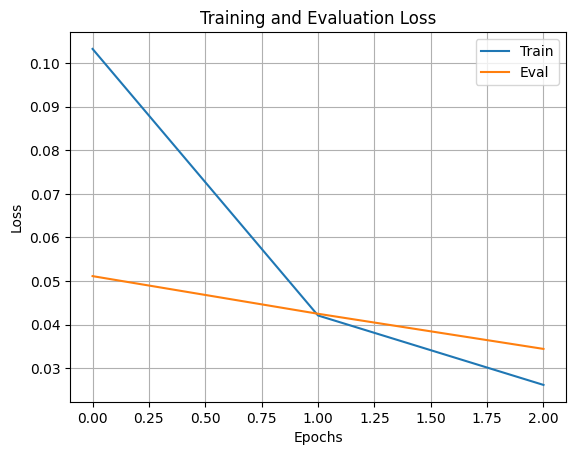

In [ ]:
# 绘制训练损失曲线
plt.plot(train_losses, label='Train')
plt.plot(eval_losses, label='Eval')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Evaluation Loss')
plt.legend()
plt.grid(True)
plt.show()

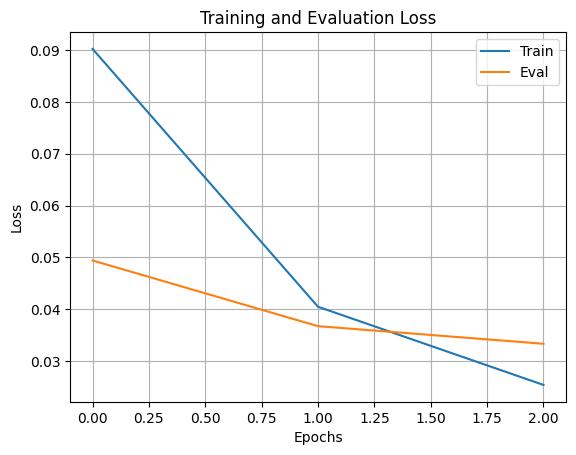

In [ ]:
# 绘制训练损失曲线
plt.plot(train_losses, label='Train')
plt.plot(eval_losses, label='Eval')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Evaluation Loss')
plt.legend()
plt.grid(True)
plt.show()

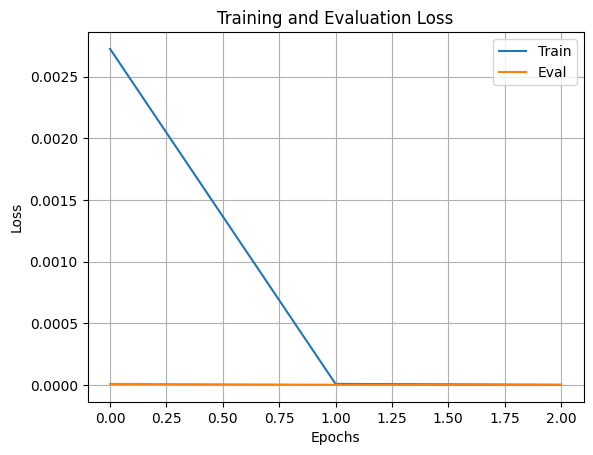

In [ ]:
# 梯度爆炸
# 绘制训练损失曲线
plt.plot(train_losses, label='Train')
plt.plot(eval_losses, label='Eval')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Evaluation Loss')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# 保存模型 保存的是文件 里面有config.json文件和model.safetensors模型文件
model.save_pretrained("./peoples_daily_ner_model")


In [ ]:
# 推理模型
# example_sentence = "海钓比赛地点在厦门与金门"
example_sentence = "北京是中国的首都。"
inputs = tokenizer(example_sentence, return_tensors="pt").to(device)
with torch.no_grad():
    outputs = model(**inputs)
    predictions = torch.argmax(outputs.logits, dim=-1).squeeze().cpu().numpy()

# 部署模型
# 你可以使用保存的模型加载并在其他地方使用，例如在Flask或FastAPI中。

In [ ]:
outputs

TokenClassifierOutput(loss=None, logits=tensor([[[ 3.9901, -1.8044, -2.8884, -1.8786, -3.3207,  3.0485,  1.5331],
         [-0.7153, -0.6476, -1.6331, -0.5521, -3.5918,  8.5403, -0.8808],
         [-1.2611, -2.8074, -0.6439, -4.1683, -1.1076, -0.6366,  8.9376],
         [10.3024, -3.0395, -2.1289, -2.9060, -1.4515, -1.7482, -0.1994],
         [-0.3421, -1.4353, -2.0323, -1.1643, -4.0647,  8.8635, -0.3588],
         [-1.1812, -2.6464, -0.5491, -4.4007, -1.2827, -0.4999,  8.9776],
         [10.1347, -2.7500, -2.6207, -3.0261, -1.8651, -1.2010,  0.0984],
         [ 9.5643, -3.0814, -2.8182, -2.7724, -2.3336, -0.1366,  0.0189],
         [ 9.0644, -3.4795, -2.9045, -2.8779, -2.1538,  0.0128,  0.5112],
         [10.1617, -3.1760, -2.8602, -2.0693, -2.1149, -1.0439, -0.4775],
         [ 3.9901, -1.8044, -2.8884, -1.8786, -3.3207,  3.0485,  1.5331]]],
       device='cuda:0'), hidden_states=None, attentions=None)

In [ ]:
predictions

array([0, 5, 6, 0, 5, 6, 0, 0, 0, 0, 0])

In [ ]:
# 推理模型
sentence = '日本外务省3月18日发布消息称，日本首相岸田文雄将于19至21日访问印度和柬埔寨。'
inputs = tokenizer(sentence, return_tensors="pt").to(device)
with torch.no_grad():
    outputs = model(**inputs)
    predictions = torch.argmax(outputs.logits, dim=-1).squeeze().cpu().numpy()

# 部署模型
# 你可以使用保存的模型加载并在其他地方使用，例如在Flask或FastAPI中。

In [ ]:
predictions

array([0, 3, 4, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 0, 0, 1,
       2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 5, 6, 0])

In [ ]:
for i in zip(list(sentence), predictions[1:-2]):
    print(i)

('日', 3)
('本', 4)
('外', 4)
('务', 4)
('省', 4)
('3', 0)
('月', 0)
('1', 0)
('8', 0)
('日', 0)
('发', 0)
('布', 0)
('消', 0)
('息', 0)
('称', 0)
('，', 0)
('日', 5)
('本', 6)
('首', 0)
('相', 0)
('岸', 1)
('田', 2)
('文', 2)
('雄', 2)
('将', 0)
('于', 0)
('1', 0)
('9', 0)
('至', 0)
('2', 0)
('1', 0)
('日', 0)
('访', 0)
('问', 5)
('印', 0)
('度', 0)
('和', 5)


In [ ]:
# 推理模型
sentence1 = '岸田文雄将于19至21日访问印度和柬埔寨。'
inputs = tokenizer(sentence1, return_tensors="pt").to(device)
with torch.no_grad():
    outputs = model(**inputs)
    predictions = torch.argmax(outputs.logits, dim=-1).squeeze().cpu().numpy()

# 部署模型
# 你可以使用保存的模型加载并在其他地方使用，例如在Flask或FastAPI中。

In [ ]:
for i in zip(list(sentence1), predictions[1:]):
    print(i)

('岸', 1)
('田', 2)
('文', 2)
('雄', 2)
('将', 0)
('于', 0)
('1', 0)
('9', 0)
('至', 0)
('2', 0)
('1', 0)
('日', 0)
('访', 0)
('问', 0)
('印', 5)
('度', 6)
('和', 0)
('柬', 5)
('埔', 6)
('寨', 0)


In [ ]:
predictions

array([0, 1, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 0, 5, 6, 0])

### 模型推理

In [ ]:
!pip install datasets